In [24]:
import pandas as pd
import numpy as np
import seaborn as sns

# todo: remove pixels from recalc that are in the sea

In [25]:
import sys
sys.path.append('./utils')
from utils_imports import *

In [26]:
res = 1
method = "TransformedTargetRegressorWithUncertainty"
tolerance = 3.0
recalc_radius = 800000

In [27]:
points = get_points("dump.sqlite", begin=pd.Timestamp("2024-1-30"), until=pd.Timestamp("2024-3-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y
points.head()

,lat,lon,wait,geometry
0,-5.688317e+06,1.867128e+07,5.0,POINT (18671284.843 -5688317.046)
1,-4.699017e+06,-7.583577e+06,15.0,POINT (-7583577.497 -4699016.755)
2,-4.602671e+06,1.961982e+07,7.0,POINT (19619822.183 -4602670.687)
3,-4.148354e+06,-6.127095e+06,10.0,POINT (-6127094.551 -4148353.673)
4,-4.116196e+06,-6.029002e+06,10.0,POINT (-6029002.261 -4116195.732)


In [28]:
map = MapBasedModel(method=method, region="world", resolution=res, version="diff_mar")
map.get_map_grid()
recalc_radius_pixels = int(np.ceil(abs(recalc_radius / (map.grid[0][0][0] - map.grid[0][0][1]))))
recalc_radius_pixels

8

In [29]:
countries = gpd.read_file(
    "map_features/countries/ne_110m_admin_0_countries.shp"
)
countries = countries.to_crs(epsg=3857)
countries = countries[countries.NAME != "Antarctica"]
country_shapes = countries.geometry
country_shapes = country_shapes.apply(lambda x: make_valid(x))

In [22]:
landmass = np.zeros(map.grid.shape[1:])

0.0

In [51]:
for x, vertical_line in tqdm(enumerate(map.grid.transpose()), total=len(map.grid.transpose())):
    for y, coords in enumerate(vertical_line):
        this_point = Point(float(coords[0]), float(coords[1]))
        landmass[y][x] = 1 if any([country_shape.contains(this_point) for country_shape in country_shapes]) else 0

  0%|          | 0/136 [00:00<?, ?it/s]

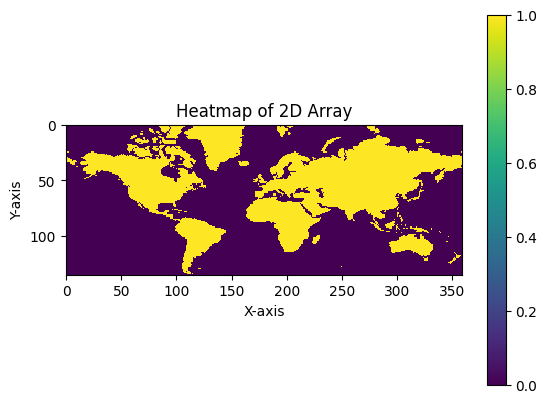

In [53]:
plt.imshow(landmass, cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()

# Add labels for better understanding (optional)
plt.title("Heatmap of 2D Array")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [54]:
def pixel_from_point(point) -> tuple[int, int]:
    lats = map.Y.transpose()[0]
    lat_index = None
    for i, lat in enumerate(lats):
        if lat >= point["lat"] and point["lat"] >= lats[i+1]:
            lat_index = i
            break

    lons = map.X[0]
    lon_index = None
    for i, lon in enumerate(lons):
        if lon <= point["lon"] and point["lon"] <= lons[i+1]:
            lon_index = i
            break

    return (lat_index, lon_index)

In [55]:
recalc = np.zeros(map.grid.shape[1:])
recalc.shape, a.shape

((136, 360), (136, 360))

In [56]:
for i, point in points.iterrows():
    lat_pixel, lon_pixel = pixel_from_point(point)

    for i in range(lat_pixel - recalc_radius_pixels, lat_pixel + recalc_radius_pixels):
        for j in range(lon_pixel - recalc_radius_pixels, lon_pixel + recalc_radius_pixels):
            if i < 0 or j < 0 or i >= recalc.shape[0] or j >= recalc.shape[1]:
                continue
            recalc[i, j] = 1

(7117.0, 48960, 0.14536356209150328)

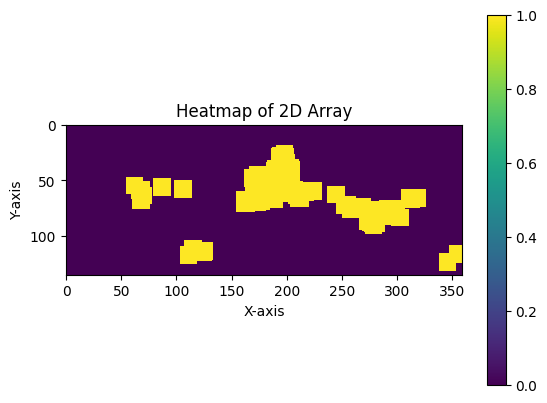

In [57]:
plt.imshow(recalc, cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()

# Add labels for better understanding (optional)
plt.title("Heatmap of 2D Array")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [60]:
recalc_landmass = recalc * landmass

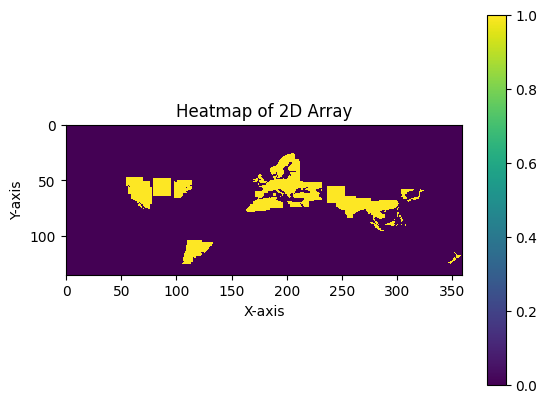

In [61]:
plt.imshow(recalc_landmass, cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()

# Add labels for better understanding (optional)
plt.title("Heatmap of 2D Array")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [62]:
print(recalc.sum(), recalc.shape[0] * recalc.shape[1], recalc.sum() / (recalc.shape[0] * recalc.shape[1]))
print(landmass.sum(), landmass.shape[0] * landmass.shape[1], landmass.sum() / (landmass.shape[0] * landmass.shape[1]))
print(recalc_landmass.sum(), recalc_landmass.shape[0] * recalc_landmass.shape[1], recalc_landmass.sum() / (recalc_landmass.shape[0] * recalc_landmass.shape[1]))

7117.0 48960 0.14536356209150328
16263.0 48960 0.3321691176470588
3948.0 48960 0.08063725490196079


In [58]:
stop

NameError: name 'stop' is not defined

# new points per 2 month spans

Months: jan - mar
Time elapsed to load countries: 0.07320237159729004
Time elapsed to load points: 0.04723334312438965
Time elapsed to transform heatmap: 0.05308055877685547


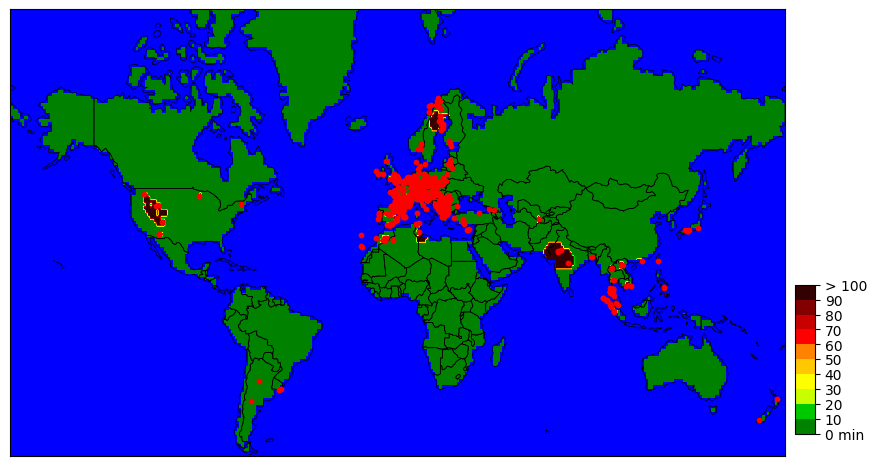

Months: mar - may
Time elapsed to load countries: 0.07260394096374512
Time elapsed to load points: 0.04903364181518555
Time elapsed to transform heatmap: 0.0516514778137207


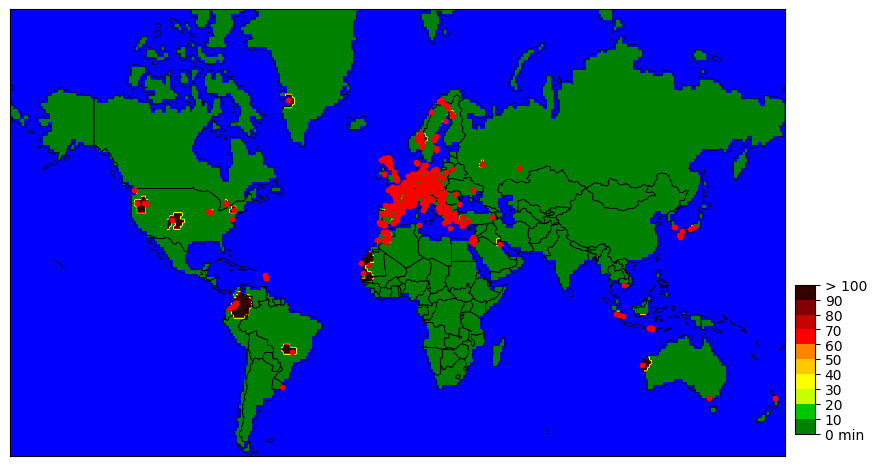

Months: may - jul
Time elapsed to load countries: 0.07197427749633789
Time elapsed to load points: 0.04748129844665527
Time elapsed to transform heatmap: 0.05258679389953613


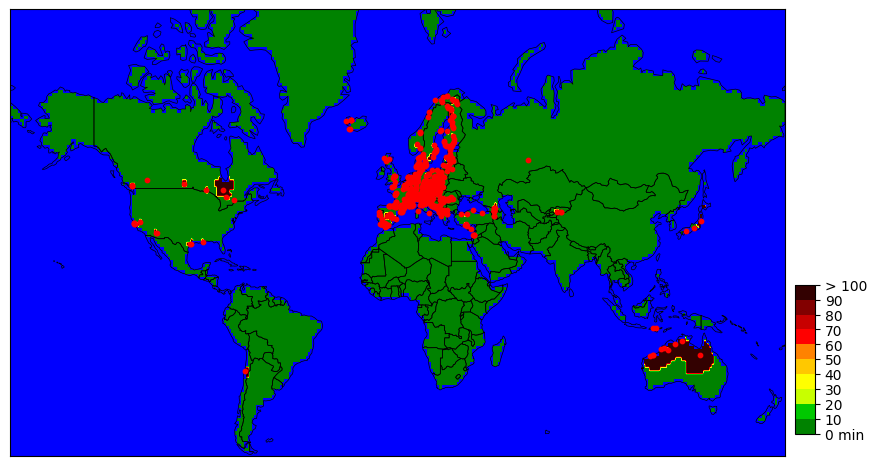

Months: jul - sep
Time elapsed to load countries: 0.0720517635345459
Time elapsed to load points: 0.0697031021118164
Time elapsed to transform heatmap: 0.05218768119812012


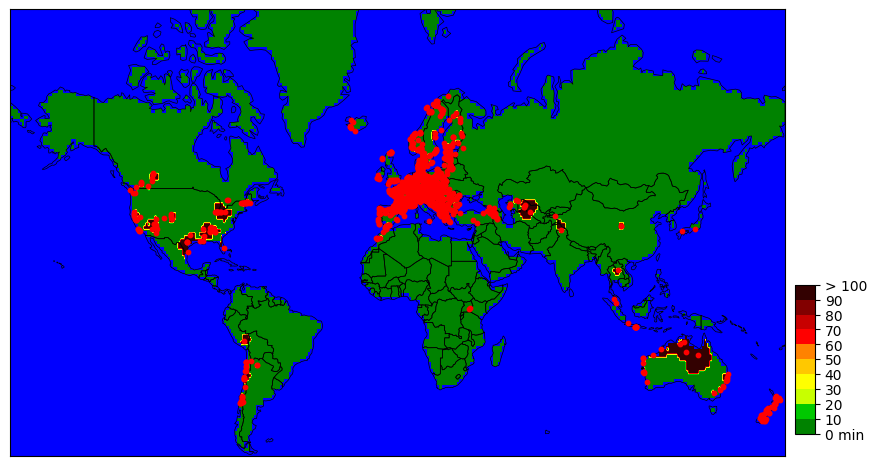

Months: sep - nov
Time elapsed to load countries: 0.07253241539001465
Time elapsed to load points: 0.04851889610290527
Time elapsed to transform heatmap: 0.05156755447387695


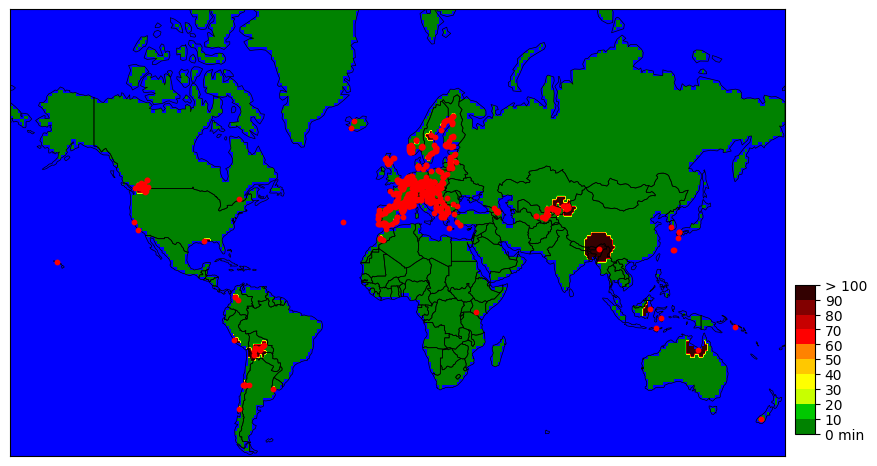

In [81]:
months = ["jan", "mar", "may", "jul", "sep", "nov"]
dates = ["2024-1-30", "2024-3-30", "2024-5-30", "2024-7-30", "2024-9-30", "2024-11-30"]

for i in range(5):
    print(f"Months: {months[i]} - {months[i+1]}")
    points = get_points("dump.sqlite", begin=pd.Timestamp(dates[i]), until=pd.Timestamp(dates[i+1]))
    points["lon"] = points.geometry.x
    points["lat"] = points.geometry.y

    map1 = load_numpy_map(resolution=res, method=method, version=months[i])
    map2 = load_numpy_map(resolution=res, method=method, version=months[i+1])
    diff = ~np.isclose(map1, map2, atol=tolerance)
    diff = diff * 100

    map = MapBasedModel(method=method, region="world", resolution=res, version="diff_mar")
    map.raw_raster = diff
    map.get_map_grid()
    map.save_as_raster()
    map.build_map(points=points, show_points=True)